# Quantum Kernel Methods for Classification using Covalent

Using quantum kernels for spam detection.

#### Referenced Tutorials
1. https://covalent.readthedocs.io/en/latest/tutorials/1_QuantumMachineLearning/classical_quantum_svm/source.html
2. https://covalent.readthedocs.io/en/latest/tutorials/1_QuantumMachineLearning/quantum_embedding_kernel/source.html

In [17]:
import os
import pandas as pd
import numpy as np
from process_data import read_data

# Import Workflow Manager (Covalent)
import covalent as ct

# Import plotting library
import matplotlib.pyplot as plt

# Set global plot background color
plt.rcParams["figure.facecolor"] = "w"

# Import for SVM classifier
from sklearn.svm import SVC

# Imports for dataset and model selection
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Imports for QSVC classifier
from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_ibm_runtime import Estimator, QiskitRuntimeService, Session

# Set the random seed for QSVC
seed = 12345
algorithm_globals.random_seed = seed

# token to access IBM Quantum compute resources
IBM_QUANTUM_TOKEN="123456789qwertyuiopzxcvbnmasdfghjkl"

In [21]:
# Ancillary functions for SVM classifiers
#@ct.electron
def get_data(nsize=100):
    X, y = read_data("./data/spambase.csv")
    rand = np.random.permutation(len(y))
    X = X[rand]
    y = y[rand]
    return X[:nsize], y[:nsize]


#@ct.electron
def split_train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
    return X_train, X_test, y_train, y_test


#@ct.electron
def train_svc(X_train, y_train):
    svc = SVC(kernel="linear")
    svc.fit(X_train, y_train)
    return svc


#@ct.electron
# def define_backend():
#     QiskitRuntimeService.save_account(channel="ibm_quantum",
#                                       token=IBM_QUANTUM_TOKEN,
#                                       instance="ibm-q-community/mit-hackathon/main",
#                                       overwrite=True)
#     return Session(service=QiskitRuntimeService(), backend="ibm_nairobi")

#@ct.electron
def train_qsvc(X_train, y_train):
    feature_map = ZZFeatureMap(5)
    backend = QuantumInstance(
        BasicAer.get_backend("qasm_simulator"), shots=100, seed_simulator=seed, seed_transpiler=seed
    )
    kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)
    qsvc = SVC(kernel=kernel.evaluate)
    qsvc.fit(X_train, y_train)
    return qsvc

# Main Workflow
#@ct.lattice
def workflow():
    X, y = get_data()
    X_train, X_test, y_train, y_test = split_train_test(X=X, y=y)
    fm = ZZFeatureMap(5)
    svc_model = train_svc(X_train=X_train, y_train=y_train)
    qsvc_model = train_qsvc(X_train=X_train, y_train=y_train)
    return X_test, y_test, svc_model, qsvc_model


In [22]:
# Dispatch workflow and obtain results
# dispatch_id = ct.dispatch(workflow)()
# result = ct.get_result(dispatch_id=dispatch_id, wait=True)
result = workflow()

In [23]:
X_test, y_test, svc_model, qsvc_model = result

In [31]:
np.average(y_test)

-0.2

In [24]:
X = [-0.61722345, -0.02207496,  0.26470189,  0.32968003, -0.1587705]
qsvc_model.predict(X)


array([-1])

Text(0.5, 1.0, 'SVC confusion matrix plot')

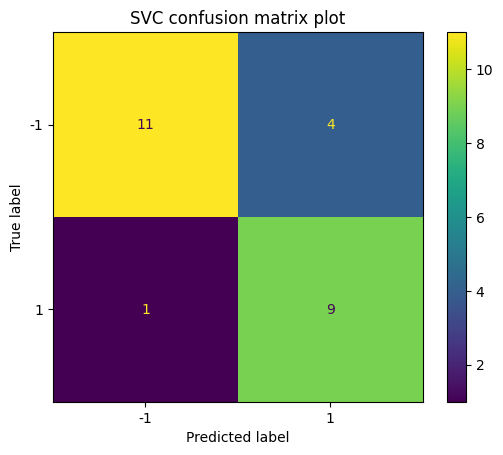

In [25]:
# Results from SVC
svc_cm_plot = ConfusionMatrixDisplay.from_estimator(svc_model, X_test, y_test)
svc_cm_plot.ax_.set_title("SVC confusion matrix plot")


Text(0.5, 1.0, 'QSVC confusion matrix plot')

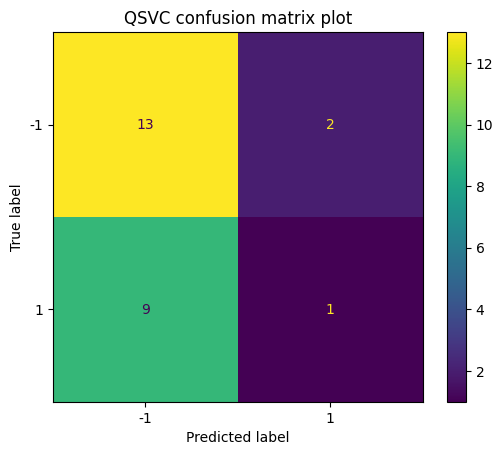

In [26]:
# Results from QSVC
qsvc_cm_plot = ConfusionMatrixDisplay.from_estimator(qsvc_model, X_test, y_test)
qsvc_cm_plot.ax_.set_title("QSVC confusion matrix plot")
